<a href="https://colab.research.google.com/github/x3O8/Gradient_Descent_Optimization/blob/main/AdaBeliefXEIm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install tensorflow numpy matplotlib scikit-learn

In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 96.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 


🔧 Training with Adam
Epoch 01: Loss=0.6448, Test Acc=0.9649
Epoch 02: Loss=0.5028, Test Acc=0.9649
Epoch 03: Loss=0.3295, Test Acc=0.9737
Epoch 04: Loss=0.1986, Test Acc=0.9737
Epoch 05: Loss=0.1440, Test Acc=0.9825
Epoch 06: Loss=0.1106, Test Acc=0.9825
Epoch 07: Loss=0.0973, Test Acc=0.9825
Epoch 08: Loss=0.0838, Test Acc=0.9825
Epoch 09: Loss=0.0736, Test Acc=0.9912
Epoch 10: Loss=0.0717, Test Acc=0.9912
Epoch 11: Loss=0.0631, Test Acc=0.9825
Epoch 12: Loss=0.0624, Test Acc=0.9825
Epoch 13: Loss=0.0584, Test Acc=0.9912
Epoch 14: Loss=0.0576, Test Acc=0.9912
Epoch 15: Loss=0.0521, Test Acc=0.9912
Epoch 16: Loss=0.0499, Test Acc=0.9825
Epoch 17: Loss=0.0473, Test Acc=0.9825
Epoch 18: Loss=0.0461, Test Acc=0.9825
Epoch 19: Loss=0.0469, Test Acc=0.9825
Epoch 20: Loss=0.0409, Test Acc=0.9825
Epoch 21: Loss=0.0396, Test Acc=0.9825
Epoch 22: Loss=0.0393, Test Acc=0.9825
Epoch 23: Loss=0.0355, Test Acc=0.9825
Epoch 24: Loss=0.0379, Test Acc=0.9737
Epoch 25: Loss=0.0332, Test Acc=0.9737
Epo

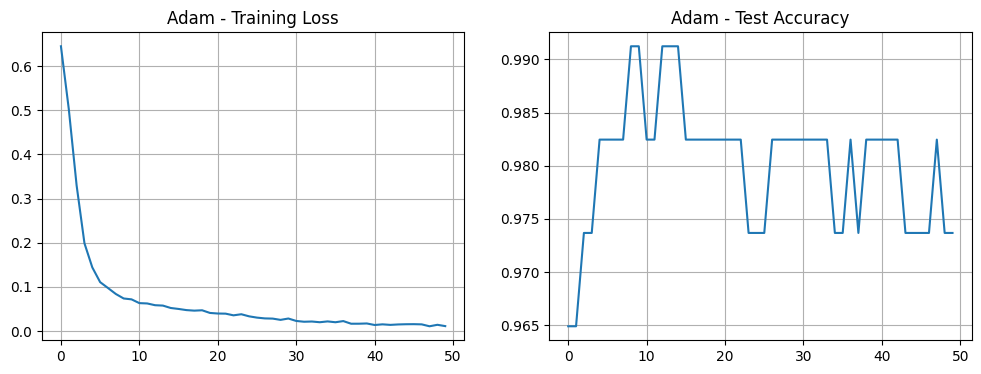

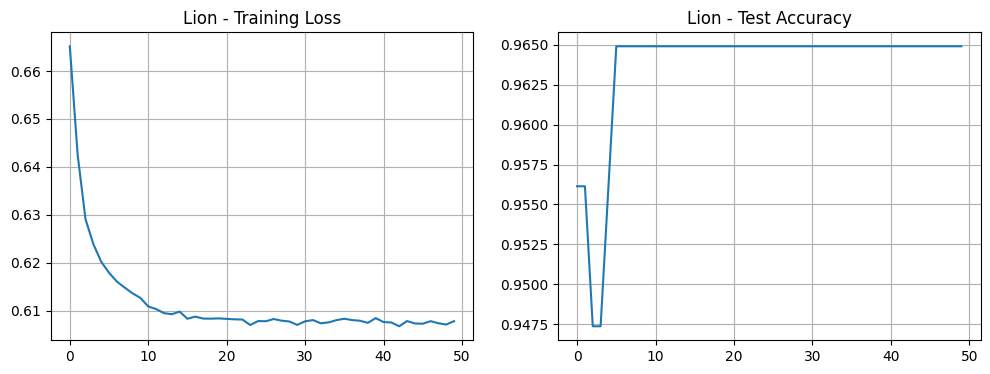

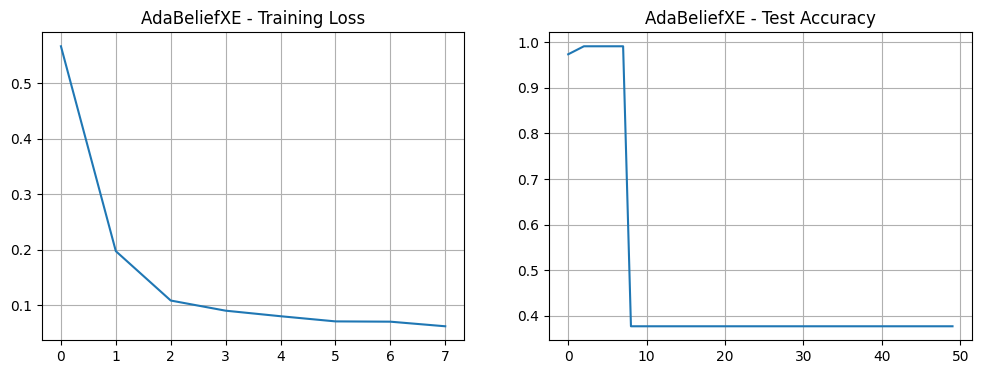

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# ==== AdaBeliefXE Optimizer ====
class AdaBeliefXE(optim.Optimizer):
    def __init__(self, params, lr=1e-3, beta1_min=0.6, beta1_max=0.95,
                 beta2_min=0.9, beta2_max=0.999, eps=1e-8, weight_decay=0,
                 alpha=0.5, total_steps=10000):
        defaults = dict(lr=lr, beta1_min=beta1_min, beta1_max=beta1_max,
                        beta2_min=beta2_min, beta2_max=beta2_max, eps=eps,
                        weight_decay=weight_decay, alpha=alpha, total_steps=total_steps, step=0)
        super(AdaBeliefXE, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("AdaBeliefXE does not support sparse gradients")

                state = self.state[p]
                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_var"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_var = state["exp_avg"], state["exp_avg_var"]
                group["step"] += 1
                step = group["step"]

                gamma = (step ** group["alpha"]) / (group["total_steps"] ** group["alpha"])
                beta1 = group["beta1_min"] + (group["beta1_max"] - group["beta1_min"]) * gamma
                beta2 = group["beta2_min"] + (group["beta2_max"] - group["beta2_min"]) * gamma

                if group["weight_decay"] != 0:
                    grad = grad.add(p.data, alpha=group["weight_decay"])

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual, grad_residual, value=1 - beta2)

                denom = exp_avg_var.sqrt().add_(group["eps"])
                step_size = group["lr"]
                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

# ==== Lion Optimizer ====
class Lion(optim.Optimizer):
    def __init__(self, params, lr=1e-4, betas=(0.95, 0.98), weight_decay=1e-2):
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super(Lion, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = closure() if closure is not None else None
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p.data)
                exp_avg = state["exp_avg"]
                beta1, beta2 = group["betas"]
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                update = exp_avg.sign() * group["lr"]
                if group["weight_decay"] != 0:
                    update += group["weight_decay"] * p.data
                p.data.add_(-update)
        return loss

# ==== Dataset ====
class BreastCancerDataset(Dataset):
    def __init__(self):
        data = load_breast_cancer()
        X = StandardScaler().fit_transform(data.data)
        y = data.target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.X_train = torch.tensor(X_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
        self.X_test = torch.tensor(X_test, dtype=torch.float32)
        self.y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    def get_loaders(self, batch_size=32):
        train_ds = torch.utils.data.TensorDataset(self.X_train, self.y_train)
        test_ds = torch.utils.data.TensorDataset(self.X_test, self.y_test)
        return DataLoader(train_ds, batch_size=batch_size, shuffle=True), DataLoader(test_ds, batch_size=batch_size)

# ==== Model ====
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

# ==== Training + Evaluation ====
def train(model, optimizer, train_loader, test_loader, epochs=50):
    criterion = nn.BCEWithLogitsLoss()
    history = {"train_loss": [], "test_acc": []}

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        history["train_loss"].append(total_loss / len(train_loader.dataset))

        # Evaluation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                logits = model(x)
                probs = torch.sigmoid(logits)
                preds = (probs > 0.5).float()
                correct += (preds == y).sum().item()
                total += y.size(0)
        acc = correct / total
        history["test_acc"].append(acc)
        print(f"Epoch {epoch+1:02d}: Loss={history['train_loss'][-1]:.4f}, Test Acc={acc:.4f}")

    return history

# ==== Run Training ====
dataset = BreastCancerDataset()
train_loader, test_loader = dataset.get_loaders(batch_size=32)

optimizers = {
    "Adam": lambda p: optim.Adam(p, lr=1e-3),
    "Lion": lambda p: Lion(p, lr=3e-4),
    "AdaBeliefXE": lambda p: AdaBeliefXE(p, lr=1e-3, total_steps=50 * len(train_loader))
}

histories = {}
for name, opt_fn in optimizers.items():
    print(f"\n🔧 Training with {name}")
    model = MLP(input_dim=30)
    optimizer = opt_fn(model.parameters())
    history = train(model, optimizer, train_loader, test_loader, epochs=50)
    histories[name] = history

# ==== Plot ====
for name, hist in histories.items():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist["train_loss"], label="Train Loss")
    plt.title(f"{name} - Training Loss")
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(hist["test_acc"], label="Test Accuracy")
    plt.title(f"{name} - Test Accuracy")
    plt.grid(True)
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
